In [ ]:
# Install necessary libraries
# !pip install qiskit qiskit-aer matplotlib numpy
# !pip install pylatexenc

In [ ]:
# Import libraries
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#BB84 Protocol

In [ ]:
# Define the main simulation function
def bb84_protocol(key_length=20, eavesdropper=False):
    """
    Simulates the BB84 protocol.

    Args:
        key_length (int): The desired length of the final secret key.
        eavesdropper (bool): If True, an eavesdropper (Eve) will intercept and measure the qubits.

    Returns:
        (bool, str, str): Success status, Alice's final key, Bob's final key.
    """
    # To get a final key of `key_length`, we start with 4x the length.
    initial_bits_count = 4 * key_length

    ## ALICE'S SIDE ##
    alice_bits = np.random.randint(2, size=initial_bits_count)
    alice_bases = np.random.randint(2, size=initial_bits_count)

    ## ENCODING QUBITS ##
    # Create a quantum circuit to encode Alice's bits and bases
    qc = QuantumCircuit(initial_bits_count, initial_bits_count)

    for i in range(initial_bits_count):
        if alice_bits[i] == 1:
            qc.x(i)
        if alice_bases[i] == 1:
            qc.h(i)

    qc.barrier()

    ## EVE'S INTERCEPTION (Optional) ##
    if eavesdropper:
        print("\n*** An Eavesdropper (Eve) is intercepting the qubits! ***")
        eve_bases = np.random.randint(2, size=initial_bits_count)
        for i in range(initial_bits_count):
            if eve_bases[i] == 1:
                qc.h(i)
            qc.measure(i, i)
            if eve_bases[i] == 1:
                qc.h(i)
        qc.barrier()

    ## BOB'S SIDE ##
    bob_bases = np.random.randint(2, size=initial_bits_count)

    for i in range(initial_bits_count):
        if bob_bases[i] == 1:
            qc.h(i)

    qc.measure(range(initial_bits_count), range(initial_bits_count))

    ## SIMULATION ##
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1)
    result = job.result()
    counts = result.get_counts()

    # Extract Bob's measured bits
    bob_measured_bits_str = list(counts.keys())[0]
    bob_measured_bits = np.array([int(bit) for bit in bob_measured_bits_str])[::-1]

    ## BASIS RECONCILIATION & SIFTING ##
    sifted_key_indices = []
    for i in range(initial_bits_count):
        if alice_bases[i] == bob_bases[i]:
            sifted_key_indices.append(i)

    alice_sifted_key = alice_bits[sifted_key_indices]
    bob_sifted_key = bob_measured_bits[sifted_key_indices]

    ## ERROR CHECKING ##
    # Take a sample of the bits to check for errors
    sample_size = min(len(alice_sifted_key), key_length) // 2
    if sample_size == 0:
        print("\nKey is too short to perform an error check. Aborting.")
        return False, "", ""

    error_count = 0
    for i in range(sample_size):
        if alice_sifted_key[i] != bob_sifted_key[i]:
            error_count += 1

    error_rate = error_count / sample_size

    if error_rate > 0.1:
        print("Error rate is too high! Eavesdropper detected. KEY DISCARDED.")
        return False, ''.join(map(str, alice_sifted_key)), ''.join(map(str, bob_sifted_key))
    else:
        print("Error rate is acceptable. Generating final key.")

        # The final key is the part of the sifted key that was NOT used for error checking
        final_key = alice_sifted_key[sample_size:]

        # Trim it to the desired key length
        final_key = final_key[:key_length]

        # For the simulation, we assume Bob's final key is the same after confirming no errors
        bob_final_key = bob_sifted_key[sample_size:][:key_length]

        if len(final_key) < key_length:
             print("\nWarning: Final key is shorter than desired length due to high discard rate.")

        return True, ''.join(map(str, final_key)), ''.join(map(str, bob_final_key))

# Run the Simulation

In [ ]:
# Run the BB84 protocol simulation
# Scenario 1: No Eavesdropper
print("--- Running simulation WITHOUT an eavesdropper ---")
success, alice_key, bob_key = bb84_protocol(key_length=7, eavesdropper=False)
if success:
    print(f"\n✅ SUCCESS: Secure key established.")
    print(f"  Final Alice Key: {alice_key}")
    print(f"  Final Bob Key:   {bob_key}")
    print(f"  Keys Match: {alice_key == bob_key}")

print("\n" + "="*50 + "\n")

# Scenario 2: With an Eavesdropper
print("--- Running simulation WITH an eavesdropper ---")
success, alice_key, bob_key = bb84_protocol(key_length=7, eavesdropper=True)
if not success:
    print(f"\n❌ PROTOCOL ABORTED as expected due to high error rate.")

--- Running simulation WITHOUT an eavesdropper ---
Error rate is acceptable. Generating final key.

✅ SUCCESS: Secure key established.
  Final Alice Key: 1111001
  Final Bob Key:   1111001
  Keys Match: True


--- Running simulation WITH an eavesdropper ---

*** An Eavesdropper (Eve) is intercepting the qubits! ***
Error rate is too high! Eavesdropper detected. KEY DISCARDED.

❌ PROTOCOL ABORTED as expected due to high error rate.


--- SECURE COMMUNICATION ANALYSIS ---
Alice's original bits: [1 1 0 1 1]
Alice's chosen bases:  [1 0 1 0 0] (0=+, 1=x)
Bob's chosen bases:    [1 1 0 0 0] (0=+, 1=x)
Bob's measured bits:   [1 0 0 1 1]

--- Sifted Keys (where bases matched) ---
Matching basis indices: [0, 3, 4]
Alice's sifted key: [1 1 1]
Bob's sifted key:   [1 1 1]

✅ Success! The sifted keys match perfectly. No eavesdropper detected.


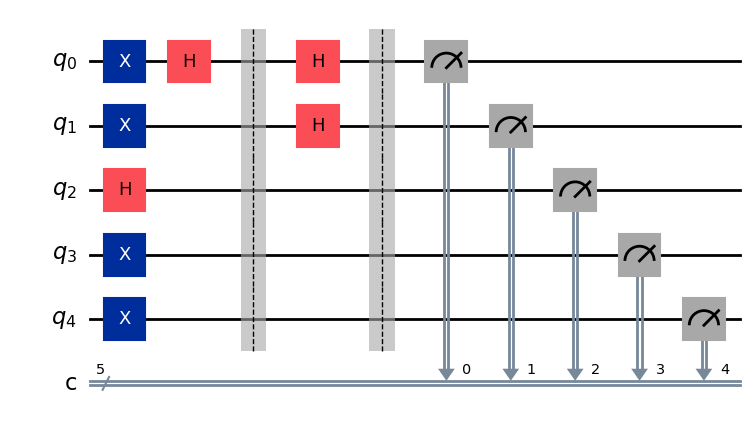

In [ ]:
# Simulate secure communication without an eavesdropper
# Setup
n = 5 # Number of qubits

# Alice's Side
alice_bits = np.random.randint(2, size=n)
alice_bases = np.random.randint(2, size=n)
qc_secure = QuantumCircuit(n, n)

for i in range(n):
    if alice_bits[i] == 1: qc_secure.x(i)
    if alice_bases[i] == 1: qc_secure.h(i)
qc_secure.barrier()

# Bob's Side
bob_bases = np.random.randint(2, size=n)
for i in range(n):
    if bob_bases[i] == 1: qc_secure.h(i)
qc_secure.barrier()

# Measurement
qc_secure.measure(range(n), range(n))

# Simulation
simulator = AerSimulator()
compiled_circuit = transpile(qc_secure, simulator)
result = simulator.run(compiled_circuit, shots=1).result()
counts = result.get_counts()
bob_measured_bits_str = list(counts.keys())[0]
bob_measured_bits = np.array([int(bit) for bit in bob_measured_bits_str])[::-1]

# Analysis
print("--- SECURE COMMUNICATION ANALYSIS ---")
print(f"Alice's original bits: {alice_bits}")
print(f"Alice's chosen bases:  {alice_bases} (0=+, 1=x)")
print(f"Bob's chosen bases:    {bob_bases} (0=+, 1=x)")
print(f"Bob's measured bits:   {bob_measured_bits}")

# Sifting: Compare bases and keep only the matching ones
sifted_key_indices = [i for i in range(n) if alice_bases[i] == bob_bases[i]]
alice_sifted_key = alice_bits[sifted_key_indices]
bob_sifted_key = bob_measured_bits[sifted_key_indices]

print("\n--- Sifted Keys (where bases matched) ---")
print(f"Matching basis indices: {sifted_key_indices}")
print(f"Alice's sifted key: {alice_sifted_key}")
print(f"Bob's sifted key:   {bob_sifted_key}")

if np.array_equal(alice_sifted_key, bob_sifted_key):
    print("\n✅ Success! The sifted keys match perfectly. No eavesdropper detected.")
else:
    print("\n❌ Error! Keys do not match. (This shouldn't happen in a noise-free simulation).")

# Draw the circuit for reference
qc_secure.draw('mpl')

--- COMPROMISED COMMUNICATION ANALYSIS ---
Alice's original bits: [1 0 1 1 0]
Alice's chosen bases:  [0 1 0 1 1] (0=+, 1=x)
Eve's chosen bases:    [0 1 0 1 1] (0=+, 1=x)
Bob's chosen bases:    [1 1 1 1 0] (0=+, 1=x)
Bob's measured bits:   [0 0 1 0 0]

--- Sifted Keys (where bases matched) ---
Matching basis indices: [1, 3]
Alice's sifted key: [0 1]
Bob's sifted key:   [0 0]

🚨 Alert! The sifted keys DO NOT match. Eavesdropper detected!
Quantum Bit Error Rate (QBER): 50.00%


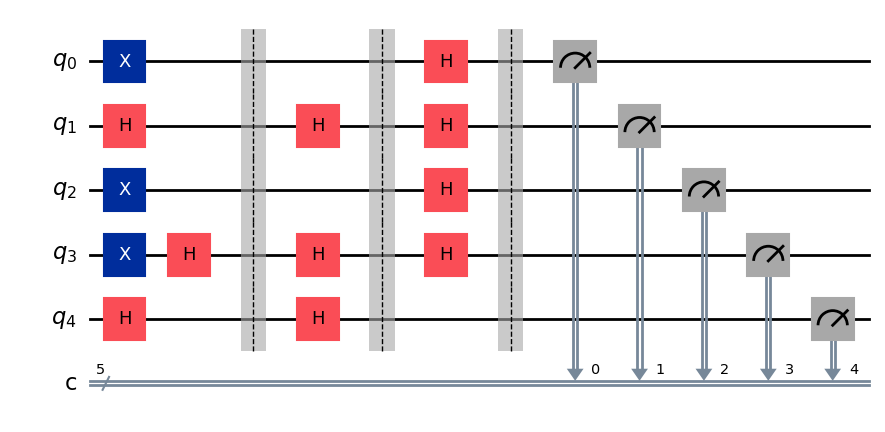

In [ ]:
# Simulate compromised communication with an eavesdropper
# Setup
n = 5

# Alice's Side
alice_bits = np.random.randint(2, size=n)
alice_bases = np.random.randint(2, size=n)
qc_eve = QuantumCircuit(n, n)

for i in range(n):
    if alice_bits[i] == 1: qc_eve.x(i)
    if alice_bases[i] == 1: qc_eve.h(i)
qc_eve.barrier()

# Eve's Side
eve_bases = np.random.randint(2, size=n)
for i in range(n):
    if eve_bases[i] == 1: qc_eve.h(i)
qc_eve.barrier()

# Bob's Side
bob_bases = np.random.randint(2, size=n)
for i in range(n):
    if bob_bases[i] == 1: qc_eve.h(i)
qc_eve.barrier()

# Measurement
qc_eve.measure(range(n), range(n))

# Simulation
simulator = AerSimulator()
compiled_circuit = transpile(qc_eve, simulator)
result = simulator.run(compiled_circuit, shots=1).result()
counts = result.get_counts()
bob_measured_bits_str = list(counts.keys())[0]
bob_measured_bits = np.array([int(bit) for bit in bob_measured_bits_str])[::-1]

# Analysis
print("--- COMPROMISED COMMUNICATION ANALYSIS ---")
print(f"Alice's original bits: {alice_bits}")
print(f"Alice's chosen bases:  {alice_bases} (0=+, 1=x)")
print(f"Eve's chosen bases:    {eve_bases} (0=+, 1=x)")
print(f"Bob's chosen bases:    {bob_bases} (0=+, 1=x)")
print(f"Bob's measured bits:   {bob_measured_bits}")

# Sifting: Compare bases
sifted_key_indices = [i for i in range(n) if alice_bases[i] == bob_bases[i]]
alice_sifted_key = alice_bits[sifted_key_indices]
bob_sifted_key = bob_measured_bits[sifted_key_indices]

print("\n--- Sifted Keys (where bases matched) ---")
print(f"Matching basis indices: {sifted_key_indices}")
print(f"Alice's sifted key: {alice_sifted_key}")
print(f"Bob's sifted key:   {bob_sifted_key}")

if not np.array_equal(alice_sifted_key, bob_sifted_key):
    print("\n🚨 Alert! The sifted keys DO NOT match. Eavesdropper detected!")
    error_rate = np.sum(alice_sifted_key != bob_sifted_key) / len(alice_sifted_key) if len(alice_sifted_key) > 0 else 0
    print(f"Quantum Bit Error Rate (QBER): {error_rate:.2%}")
else:
    print("\n⚠️ No errors detected. Eve might have gotten lucky with her basis choices.")

# Draw the circuit for reference
qc_eve.draw('mpl')